## Saving and Loading Models
Saving and Loading is important because you'll often want to load previously trained models to use in the making predictions or to continue training on new data.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

import helper


<Figure size 432x288 with 0 Axes>

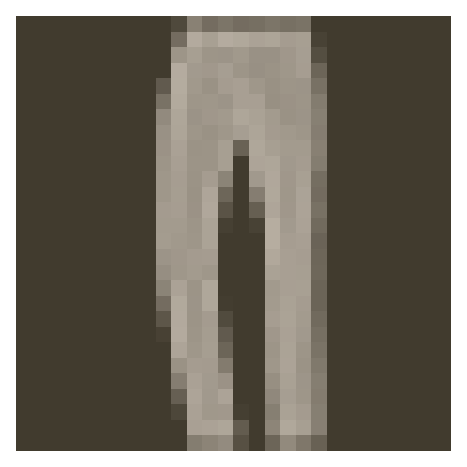

In [5]:
# Deifne a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_date1', download=True, train=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_date1', download=True, train=True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

image, label = next(iter(trainloader))
helper.imshow(image[0,:]);


In [6]:
from torch import nn, optim
import torch.nn.functional as F

# Define network architecture
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # Output so not dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        return x
    

In [7]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss +=loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        # turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval() # truns off the dropout
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        


Epoch: 1/10..  Training Loss: 0.601..  Test Loss: 0.429..  Test Accuracy: 0.845
Epoch: 2/10..  Training Loss: 0.480..  Test Loss: 0.386..  Test Accuracy: 0.863
Epoch: 3/10..  Training Loss: 0.449..  Test Loss: 0.377..  Test Accuracy: 0.863
Epoch: 4/10..  Training Loss: 0.430..  Test Loss: 0.349..  Test Accuracy: 0.873
Epoch: 5/10..  Training Loss: 0.414..  Test Loss: 0.355..  Test Accuracy: 0.865
Epoch: 6/10..  Training Loss: 0.415..  Test Loss: 0.332..  Test Accuracy: 0.875
Epoch: 7/10..  Training Loss: 0.402..  Test Loss: 0.316..  Test Accuracy: 0.885
Epoch: 8/10..  Training Loss: 0.399..  Test Loss: 0.322..  Test Accuracy: 0.882
Epoch: 9/10..  Training Loss: 0.393..  Test Loss: 0.336..  Test Accuracy: 0.879
Epoch: 10/10..  Training Loss: 0.387..  Test Loss: 0.306..  Test Accuracy: 0.888


In [8]:
print("our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

our model: 

 Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


The simplest thing to do is simply save the state dict with `torch.save`. For example, we can save it to a file `'checkpoint.pth'`


In [9]:
torch.save(model.state_dict(),'checkpoint.pth')

Then we can load the state dict with `torch.load`.

In [10]:
state_dict = torch.load('checkpoint.pth')

In [11]:
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


And to load the state dict in to the network, you do `model.load_state_dict(state_dict)`

In [13]:
model.load_state_dict(state_dict)

### Note
Seems pretty straightforwar, but as usual it's a bit more complicated. Loading the state dict works only if the model architecture is exactly the same as the checkpoint architecture. If I create a model with a different architecture, this fails